# Visual Question Answering

**Authors:** [Mohamed Reda Bouadjenek](https://rbouadjenek.github.io/)<br>

**Date created:** 2021/10/24<br>

**Last modified:** 2021/10/24<br>

**Description:** Training a Visual Question Answering model.


## Introduction


Visual Question Answering (VQA) is the task of providing an accurate natural language answer to a natural language question about a particular image. Visual questions selectively target different areas of an image, including background details and underlying context. As a result, a system that succeeds at VQA typically needs a more detailed understanding of the image and complex reasoning than a system producing generic image captions.

This demonstration shows how to combine a pre-trained VGG19 network and a RNN to build an VQA system. The model we create is similar to the one described by [Agrawal et al. 2015](https://arxiv.org/pdf/1505.00468.pdf) in Figure 8.

We will use the VQA V2 dataset from the [VQA: Visual Question Ansewering](https://visualqa.org/) project. It consists of Images, Questions, and the corresponding answers (labels).

We will evaluate the quality of the model using a new evaluation metric which is robust to inter-human variability in phrasing the answers: [Accuracy_vqa](https://visualqa.org/evaluation.html).
If you are using Google Colab, you can get the package using the following:



In [ ]:
!mkdir vqaEvaluation/
!wget --output-document=vqaEvaluation/vqa.py https://raw.githubusercontent.com/rbouadjenek/deakin-ai-challenge2022/main/vqaEvaluation/vqa.py > /dev/null 2> /dev/null
!wget --output-document=vqaEvaluation/vqaEval.py https://raw.githubusercontent.com/rbouadjenek/deakin-ai-challenge2022/main/vqaEvaluation/vqaEval.py > /dev/null 2> /dev/null


**References:**

- [VQA: Visual Question Ansewering](https://visualqa.org/)
- [VQA: Visual Question Answering (ICCV 2015)](https://arxiv.org/pdf/1505.00468.pdf)


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import json
import os
import numpy as np
from sklearn.utils import shuffle
from tensorflow.keras.utils import plot_model
from vqaEvaluation.vqaEval import VQAEval
from vqaEvaluation.vqa import VQA
from IPython.display import Image, display
import matplotlib.cm as cm


## Downloading Dataset

In [3]:
# Traning Images
data_url = "http://206.12.93.90:8080/simpson2022_dataset/scene_img_abstract_v002_train2015.tar.gz"
zip_path = keras.utils.get_file("scene_img_abstract_v002_train2015.tar.gz", data_url, extract=True)
imgs_path_train = os.path.dirname(zip_path) + '/scene_img_abstract_v002_train2015/'

#  Validation Images
data_url = "http://206.12.93.90:8080/simpson2022_dataset/scene_img_abstract_v002_val2015.tar.gz"
zip_path = keras.utils.get_file("scene_img_abstract_v002_val2015.tar.gz", data_url, extract=True)
imgs_path_val = os.path.dirname(zip_path) + '/scene_img_abstract_v002_val2015/'

# Traning Questions
data_url = "http://206.12.93.90:8080/simpson2022_dataset/OpenEnded_abstract_v002_train2015_questions.zip"
zip_path = keras.utils.get_file("OpenEnded_abstract_v002_train2015_questions.zip", data_url,
                                cache_subdir='datasets/OpenEnded_abstract_v002_train2015_questions/', extract=True)
q_train_file = os.path.dirname(zip_path) + '/OpenEnded_abstract_v002_train2015_questions.json'

#  Validation Questions
data_url = "http://206.12.93.90:8080/simpson2022_dataset/OpenEnded_abstract_v002_val2015_questions.zip"
zip_path = keras.utils.get_file("OpenEnded_abstract_v002_val2015_questions.zip", data_url,
                                cache_subdir='datasets/OpenEnded_abstract_v002_val2015_questions/', extract=True)
q_val_file = os.path.dirname(zip_path) + '/OpenEnded_abstract_v002_val2015_questions.json'

# Traning Annotations
data_url = "http://206.12.93.90:8080/simpson2022_dataset/abstract_v002_train2015_annotations.zip"
zip_path = keras.utils.get_file("abstract_v002_train2015_annotations.zip", data_url,
                                cache_subdir='datasets/abstract_v002_train2015_annotations/', extract=True)
anno_train_file = os.path.dirname(zip_path) + '/abstract_v002_train2015_annotations.json'

# Validation Annotations
data_url = "http://206.12.93.90:8080/simpson2022_dataset/abstract_v002_val2015_annotations.zip"
zip_path = keras.utils.get_file("abstract_v002_val2015_annotations.zip", data_url,
                                cache_subdir='datasets/abstract_v002_val2015_annotations/', extract=True)
anno_val_file = os.path.dirname(zip_path) + '/abstract_v002_val2015_annotations.json'


## Data preprocessing

In [21]:
# Read the data files
q_train = json.load(open(q_train_file))
q_val = json.load(open(q_val_file))
anno_train = json.load(open(anno_train_file))
anno_val = json.load(open(anno_val_file))

# Select top 1000 answers to be used
num_answers = 100
answers = {}
for annotation in anno_train['annotations']:
    answer = annotation['multiple_choice_answer']
    v = answers.get(answer, 0)
    answers[answer] = v + 1
answers = list(dict(sorted(answers.items(), key=lambda x: -x[1])[0:num_answers]).keys())


# Filter questions for which the anwers are not in the top 1000
def filter_questions(questions, annotations, answers, imgs_path):
    # Make sure the questions and annotations are alligned
    questions['questions'] = sorted(questions['questions'], key=lambda x: x['question_id'])
    annotations['annotations'] = sorted(annotations['annotations'], key=lambda x: x['question_id'])
    q_out = []
    anno_out = []
    imgs_out = []
    q_ids = []
    question_ids_set = set()
    # Filter annotations
    for annotation in annotations['annotations']:
        if annotation['multiple_choice_answer'] in answers:
            question_ids_set.add(annotation['question_id'])
            q_ids.append(annotation['question_id'])
            anno_out.append(answers.index(annotation['multiple_choice_answer']))
    # Filter images and questions
    for q in questions['questions']:
        if q['question_id'] in question_ids_set:
            # Preprocessing the question
            q_text = q['question'].lower()
            q_text = q_text.replace('?', ' ? ')
            q_text = q_text.replace('.', ' . ')
            q_text = q_text.replace(',', ' . ')
            q_text = q_text.replace('!', ' . ').strip()
            q_out.append(q_text)
            file_name = str(q['image_id'])
            while len(file_name) != 12:
                file_name = '0' + file_name
            file_name = imgs_path + 'abstract_v002_' + annotations['data_subtype'] + '_' + file_name + '.png'
            imgs_out.append(file_name)
    return imgs_out, q_out, anno_out, q_ids


imgs_train, q_train, anno_train, q_ids_train = filter_questions(q_train, anno_train,
                                                                answers, imgs_path_train)
imgs_train, q_train, anno_train, q_ids_train = shuffle(imgs_train, q_train,
                                                       anno_train, q_ids_train, random_state=0)

imgs_val, q_val, anno_val, q_ids_val = filter_questions(q_val, anno_val,
                                                        answers, imgs_path_val)
imgs_val, q_val, anno_val, q_ids_val = shuffle(imgs_val, q_val,
                                               anno_val, q_ids_val, random_state=0)



In [22]:
print(answers)

['yes', 'no', '2', '1', 'red', '3', 'white', 'yellow', 'blue', '4', 'dog', 'brown', '0', 'cat', '5', 'sitting', 'green', 'black', 'gray', 'wine', 'playing', 'soccer', 'floor', 'couch', 'table', 'right', 'woman', 'football', 'food', 'nothing', 'rug', 'watermelon', 'left', 'plant', 'girl', 'orange', 'sleeping', 'log', 'boy', 'bench', 'blanket', 'man', 'monkey bars', 'stool', 'apple', 'standing', 'sunny', 'grass', 'bird', 'bike', 'bone', 'sandbox', 'pie', 'book', 'baseball', 'chair', 'scooter', 'squirrel', 'tan', 'picture', 'yarn', 'tree', 'tv', 'beehive', 'mouse', 'pond', 'baby', 'steak', 'sun', 'skateboard', 'jumping', 'walking', 'no one', 'duck', 'red and white', 'fireplace', 'teddy bear', 'floral', 'fire', 'deer', 'dancing', '6', 'slide', 'logs', 'happy', 'sky', 'sidewalk', 'sunset', 'soccer ball', 'raccoon', 'fish', 'pink', 'ribs', 'flowers', 'frisbee', 'turtle', 'sand', 'coat rack', 'blocks', 'running']


Let's create the objects that will be used for evaluation.
See: https://visualqa.org/evaluation.html.


In [5]:
# Create vqa object and vqaRes object which will be used for evaluation
vqa_train = VQA(anno_train_file, q_train_file)
vqa_val = VQA(anno_val_file, q_val_file)


loading VQA annotations and questions into memory...
0:00:00.678674
creating index...
index created!
loading VQA annotations and questions into memory...
0:00:00.478906
creating index...
index created!


We now prepare the vocabulary to be used.


In [6]:
# Get the vocabulary
vocab_size = 15000
vocab = {}
for q in q_train:
    q = q.split(' ')
    for token in q:
        v = vocab.get(token, 0)
        vocab[token] = v + 1
vocab = list(dict(sorted(vocab.items(), key=lambda x: -x[1])[0:vocab_size]).keys())
# Mapping tokens to integers
token_to_num = keras.layers.StringLookup(vocabulary=vocab)
# Mapping integers back to original tokens
num_to_token = keras.layers.StringLookup(vocabulary=token_to_num.get_vocabulary(),
                                         invert=True)
vocab_size = token_to_num.vocab_size()
print(f"The size of the vocabulary ={token_to_num.vocab_size()}")
print("Top 20 tokens in the vocabulary: ", token_to_num.get_vocabulary()[:20])


The size of the vocabulary =4212
Top 20 tokens in the vocabulary:  ['[UNK]', '?', 'the', 'is', 'are', 'what', 'how', 'many', 'on', 'in', 'color', 'there', 'a', 'to', 'man', 'of', 'woman', 'dog', 'girl', 'boy']


2022-03-10 13:35:35.582189: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-10 13:35:36.462453: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8946 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:65:00.0, compute capability: 7.5


## Defining Map Functions

In [7]:
def encode_single_sample(img_file, q, anno):
    ###########################################
    ##  Process the Image
    ##########################################
    # 1. Read image file  
    img = tf.io.read_file(img_file)
    # 2. Decode the image
    img = tf.image.decode_jpeg(img, channels=3)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    ###########################################
    ##  Process the question
    ##########################################
    # 5. Split into list of tokens
    word_splits = tf.strings.split(q, sep=" ")
    # 6. Map tokens to indices
    q = token_to_num(word_splits)
    # 7. Return a inputs to for the model
    return (img, q), anno


## Creating `Dataset` objects

We create our `tf.data.Dataset` object that returns a new dataset containing the transformed elements, in the same order as they appeared in the input. The function `encode_single_sample` is used to change both the values and the structure of a dataset's elements.



In [8]:
batch_size = 128
# Desired image dimensions
img_width = 64
img_height = 64
image_size = (img_height, img_width)
# Define the trainig dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (imgs_train, q_train, anno_train)
)
train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
        .padded_batch(batch_size)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
)
# Define the validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices(
    (imgs_val, q_val, anno_val)
)
val_dataset = (
    val_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
        .padded_batch(batch_size)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
)


## Visualize the data

Let's visualize an example in our dataset, including the image, the question, and the corresponding answer.


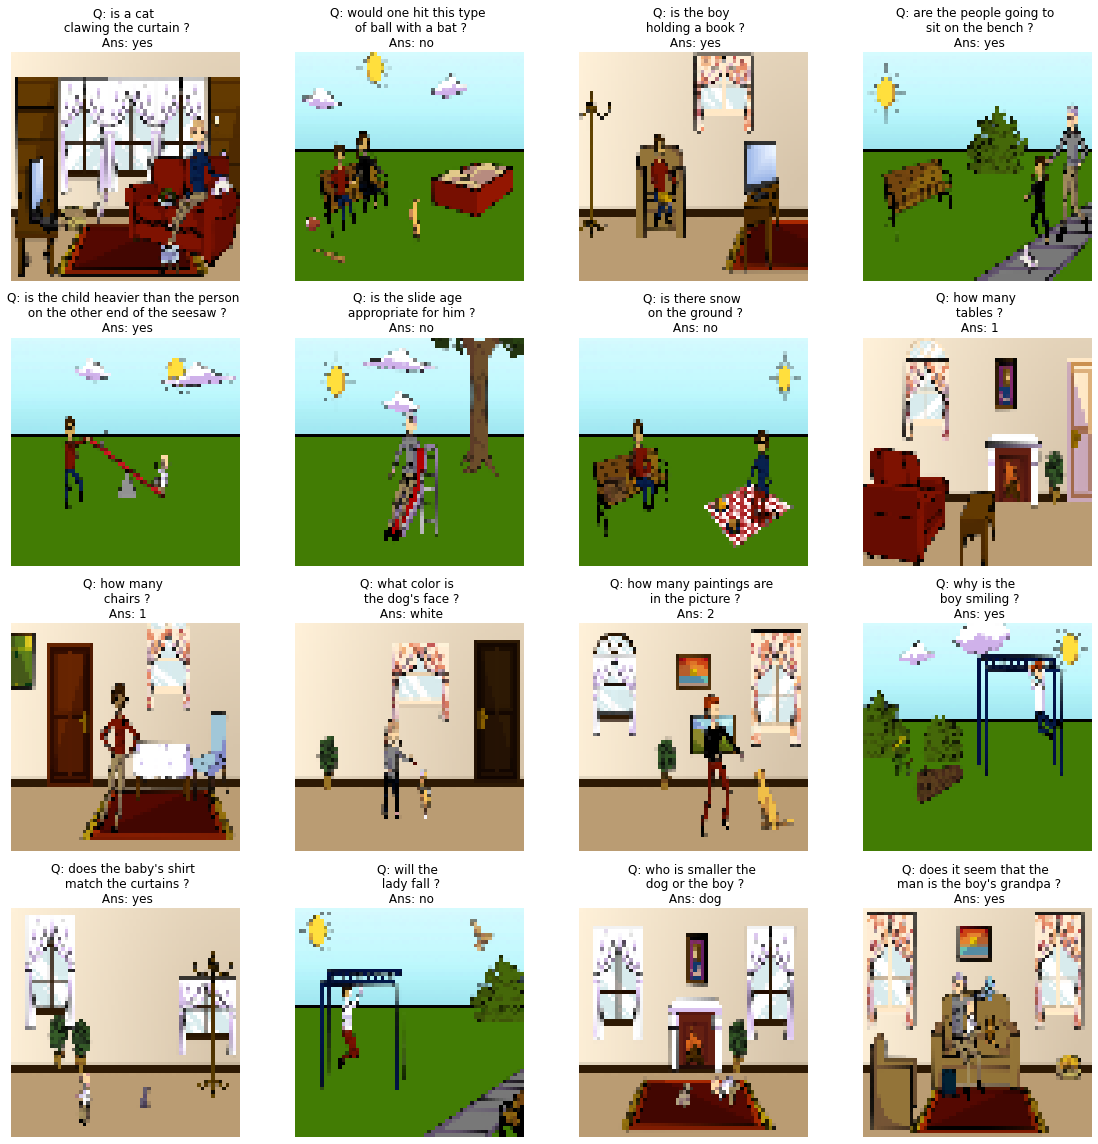

In [9]:
#  Let's check results on some validation samples
for batch in val_dataset.shuffle(20).take(1):
    imgs_batch = batch[0][0]
    q_batch = batch[0][1]
    ans_batch = batch[1]
    answer_texts = [answers[i] for i in ans_batch]

    q_orig = []
    for q in q_batch:
        q = num_to_token(q).numpy()
        q = [t.decode("utf-8") for t in q]
        q = list(filter(('[UNK]').__ne__, q))
        q.insert(int(len(q) / 2), '\n')
        q = ' '.join(q)
        q_orig.append(q)

    _, ax = plt.subplots(4, 4, figsize=(16, 16))
    for i in range(16):
        img = (imgs_batch[i, :, :, :] * 255).numpy().astype(np.uint8)
        title = f"Q: {q_orig[i]}\n Ans: {answer_texts[i]}"
        ax[i // 4, i % 4].imshow(img)
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

    plt.tight_layout()
    plt.show()


## Model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 64, 64, 64)   1792        ['input_1[0][0]']                
                                                                                                  
 block1_conv2 (Conv2D)          (None, 64, 64, 64)   36928       ['block1_conv1[0][0]']           
                                                                                                  
 block1_pool (MaxPooling2D)     (None, 32, 32, 64)   0           ['block1_conv2[0][0]']           
                                                                                              

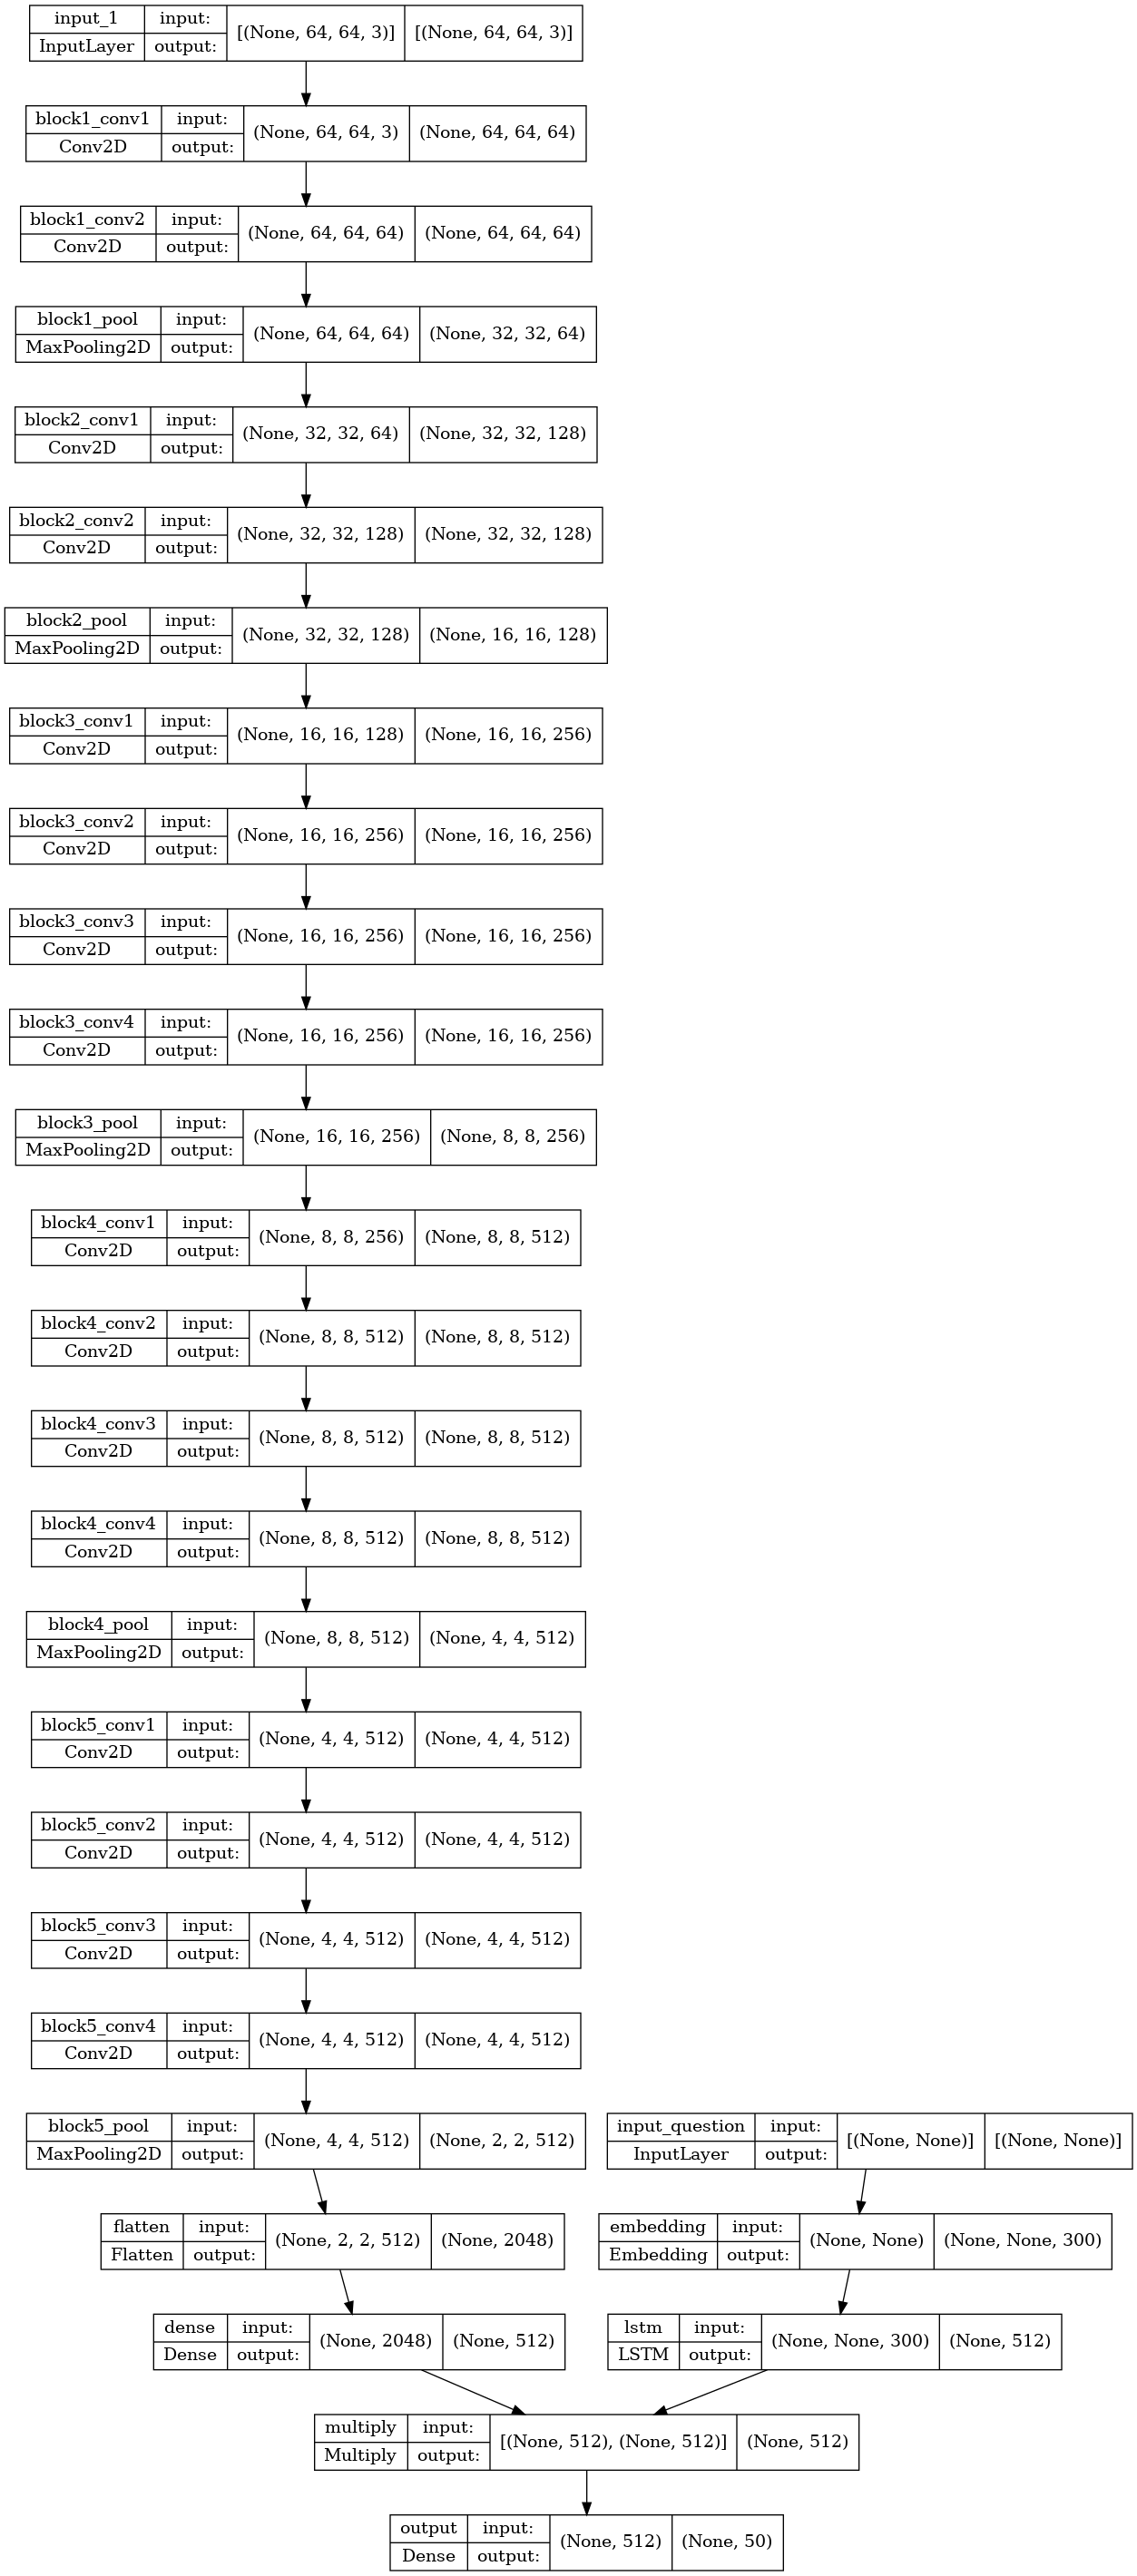

In [10]:
# This model is the deeper LSTM Q from Figure 8 in
# https://arxiv.org/pdf/1505.00468.pdf
def build_model(img_size, vocab_size, num_answers):
    # Define the VGG19 conv_base for image input
    conv_base = keras.applications.vgg19.VGG19(include_top=False,
                                               weights="imagenet",
                                               input_shape=img_size + (3,))
    conv_base.trainable = False  # Freeze the conv_base model
    img = layers.Flatten()(conv_base.layers[-1].output)
    img = layers.Dense(512, activation='tanh')(img)
    #Define RNN for language input
    q_input = keras.Input(shape=(None,), name="input_question")
    q = layers.Embedding(input_dim=vocab_size, output_dim=300)(q_input)
    q = layers.LSTM(512)(q)
    # Combine CNN and RNN
    mrg = layers.Multiply()([img, q])
    # Output    
    output = layers.Dense(num_answers, activation='softmax', name="output")(mrg)
    vqa_model = keras.Model(inputs=[conv_base.inputs, q_input], outputs=output)
    vqa_model.compile(keras.optimizers.Adam(learning_rate=1e-4),
                      loss='sparse_categorical_crossentropy')
    return vqa_model


# Get the model
model = build_model(image_size, vocab_size, num_answers)
model.summary()
plot_model(model, show_shapes=True)


## Training and Evaluating

In [11]:
# A utility function assess the model using the metrics suggested in:
# https://visualqa.org/evaluation.html.
def evaluate_model(model, dataset, vqa, q_ids, q_file):
    preds = model.predict(dataset)
    preds = np.argmax(preds, axis=1)
    res = []
    for i in range(len(preds)):
        res.append({'question_id': q_ids[i], "answer": answers[preds[i]]})
    vqaRes = vqa.loadRes(res, q_file)
    # create vqaEval object by taking vqa and vqaRes
    vqaEval = VQAEval(vqa, vqaRes, n=4)
    # evaluate results
    vqaEval.evaluate(quesIds=q_ids)
    return vqaEval


# A callback class to check overall accuracy as suggested in
# https://visualqa.org/evaluation.html.
class CallbackEval(keras.callbacks.Callback):
    """Displays Accuracy for each epoch."""

    def __init__(self, dataset, vqa, q_ids, q_file, data_type='training'):
        super().__init__()
        self.dataset = dataset
        self.vqa = vqa
        self.q_ids = q_ids
        self.q_file = q_file
        self.overall_accuracy = []
        self.data_type = data_type

    def on_epoch_end(self, epoch: int, logs=None):
        vqaEval = evaluate_model(model, self.dataset,
                                 self.vqa,
                                 self.q_ids,
                                 self.q_file)
        self.overall_accuracy.append(vqaEval.accuracy['overall'])
        print('-' * 50)
        print("Epoch: " + str(epoch + 1) +
              " - Overall Accuracy for " + self.data_type +
              " set is: %.02f" % (vqaEval.accuracy['overall']))
        print('-' * 50)


In [12]:
# Define the number of epochs.
epochs = 10
# Callback functions to check overall accuracy as suggested in 
# https://visualqa.org/evaluation.html.
train_callback = CallbackEval(train_dataset,
                              vqa_train,
                              q_ids_train,
                              q_train_file)
val_callback = CallbackEval(val_dataset,
                            vqa_val,
                            q_ids_val,
                            q_val_file,
                            data_type='validation')
# Train the model
history = model.fit(
    train_dataset,
    epochs=epochs,
    callbacks=[train_callback, val_callback],
)
# Put training data in the history
history.history['overall_accuracy'] = train_callback.overall_accuracy
history.history['val_overall_accuracy'] = val_callback.overall_accuracy



Epoch 1/10


2022-03-10 13:36:21.977049: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2022-03-10 13:36:23.277346: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


352/352 [==============================] - ETA: 0s - loss: 2.3820Loading and preparing results...     
DONE (t=0.06s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% Done computing accuracy
--------------------------------------------------
Epoch: 1 - Overall Accuracy for training set is: 48.16
--------------------------------------------------
Loading and preparing results...     
DONE (t=0.03s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% Done computing accuracy
--------------------------------------------------
Epoch: 1 - Overall Accuracy for validation set is: 48.46
--------------------------------------------------
352/352 [==============================] - 141s 386ms/step - loss: 2.3820
Epoch 2/10
352/352 [==============================] - ETA: 0s - loss: 1.6074Loading and preparing results...     
DONE (t=0.07s)
creating index...
index created!
computing accuracy
Finshed Percent: [

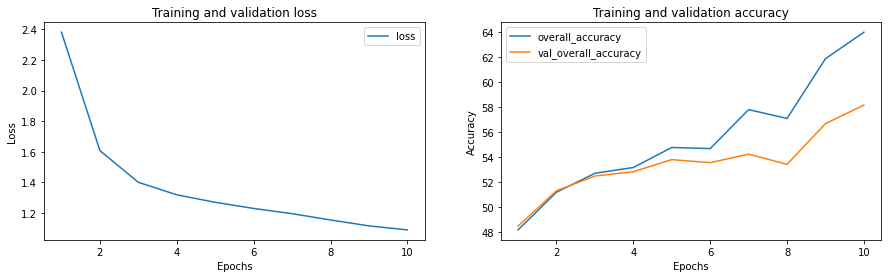

In [13]:
def learning_plots(history):
    plt.figure(figsize=(15, 4))
    ax1 = plt.subplot(1, 2, 1)
    for l in history.history:
        if l == 'loss' or l == 'val_loss':
            loss = history.history[l]
            plt.plot(range(1, len(loss) + 1), loss, label=l)

    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    ax2 = plt.subplot(1, 2, 2)
    for k in history.history:
        if 'accuracy' in k:
            loss = history.history[k]
            plt.plot(range(1, len(loss) + 1), loss, label=k)
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


learning_plots(history)


In [14]:
vqaEval_val = evaluate_model(model, val_dataset, vqa_val, q_ids_val, q_val_file)
print("Overall Accuracy is: %.02f\n" % (vqaEval_val.accuracy['overall']))
print("Per Answer Type Accuracy is the following:")
for ansType in vqaEval_val.accuracy['perAnswerType']:
    print("%s : %.02f" % (ansType, vqaEval_val.accuracy['perAnswerType'][ansType]))


Loading and preparing results...     
DONE (t=0.03s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% Done computing accuracy
Overall Accuracy is: 58.16

Per Answer Type Accuracy is the following:
number : 48.52
yes/no : 74.58
other : 31.91


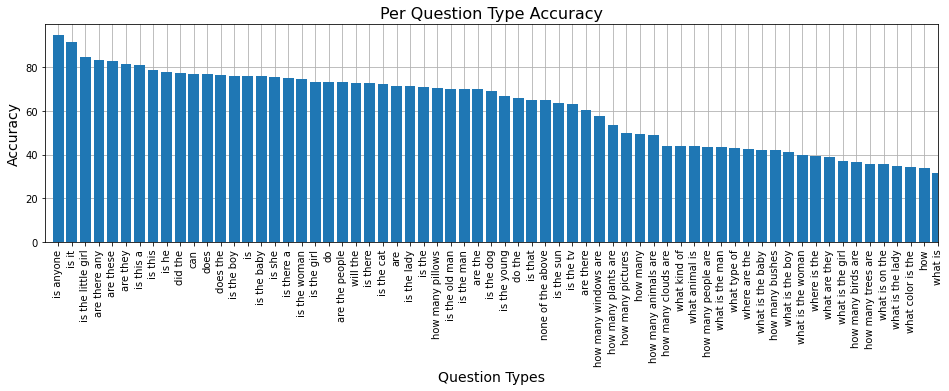

In [15]:
# plot accuracy for various question types
data = dict(sorted(vqaEval_val.accuracy['perQuestionType'].items(), key=lambda x: -x[1]))
plt.figure(figsize=(16, 4))
plt.grid()
plt.gca().set_axisbelow(True)
plt.bar(range(len(data)), data.values(), align='center')
plt.xticks(range(len(data)), data.keys(), rotation='90', fontsize=10)
plt.title('Per Question Type Accuracy', fontsize=16)
plt.xlabel('Question Types', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xlim(-1, 65)
plt.show()


## Inference and visualization


### The Grad-CAM algorithm 
The code in this section is adapted from this example:
https://keras.io/examples/vision/grad_cam/

In [16]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [17]:
def get_gradcam(img, heatmap, alpha=0.005):
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)
    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")
    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)
    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    return superimposed_img


### Inference

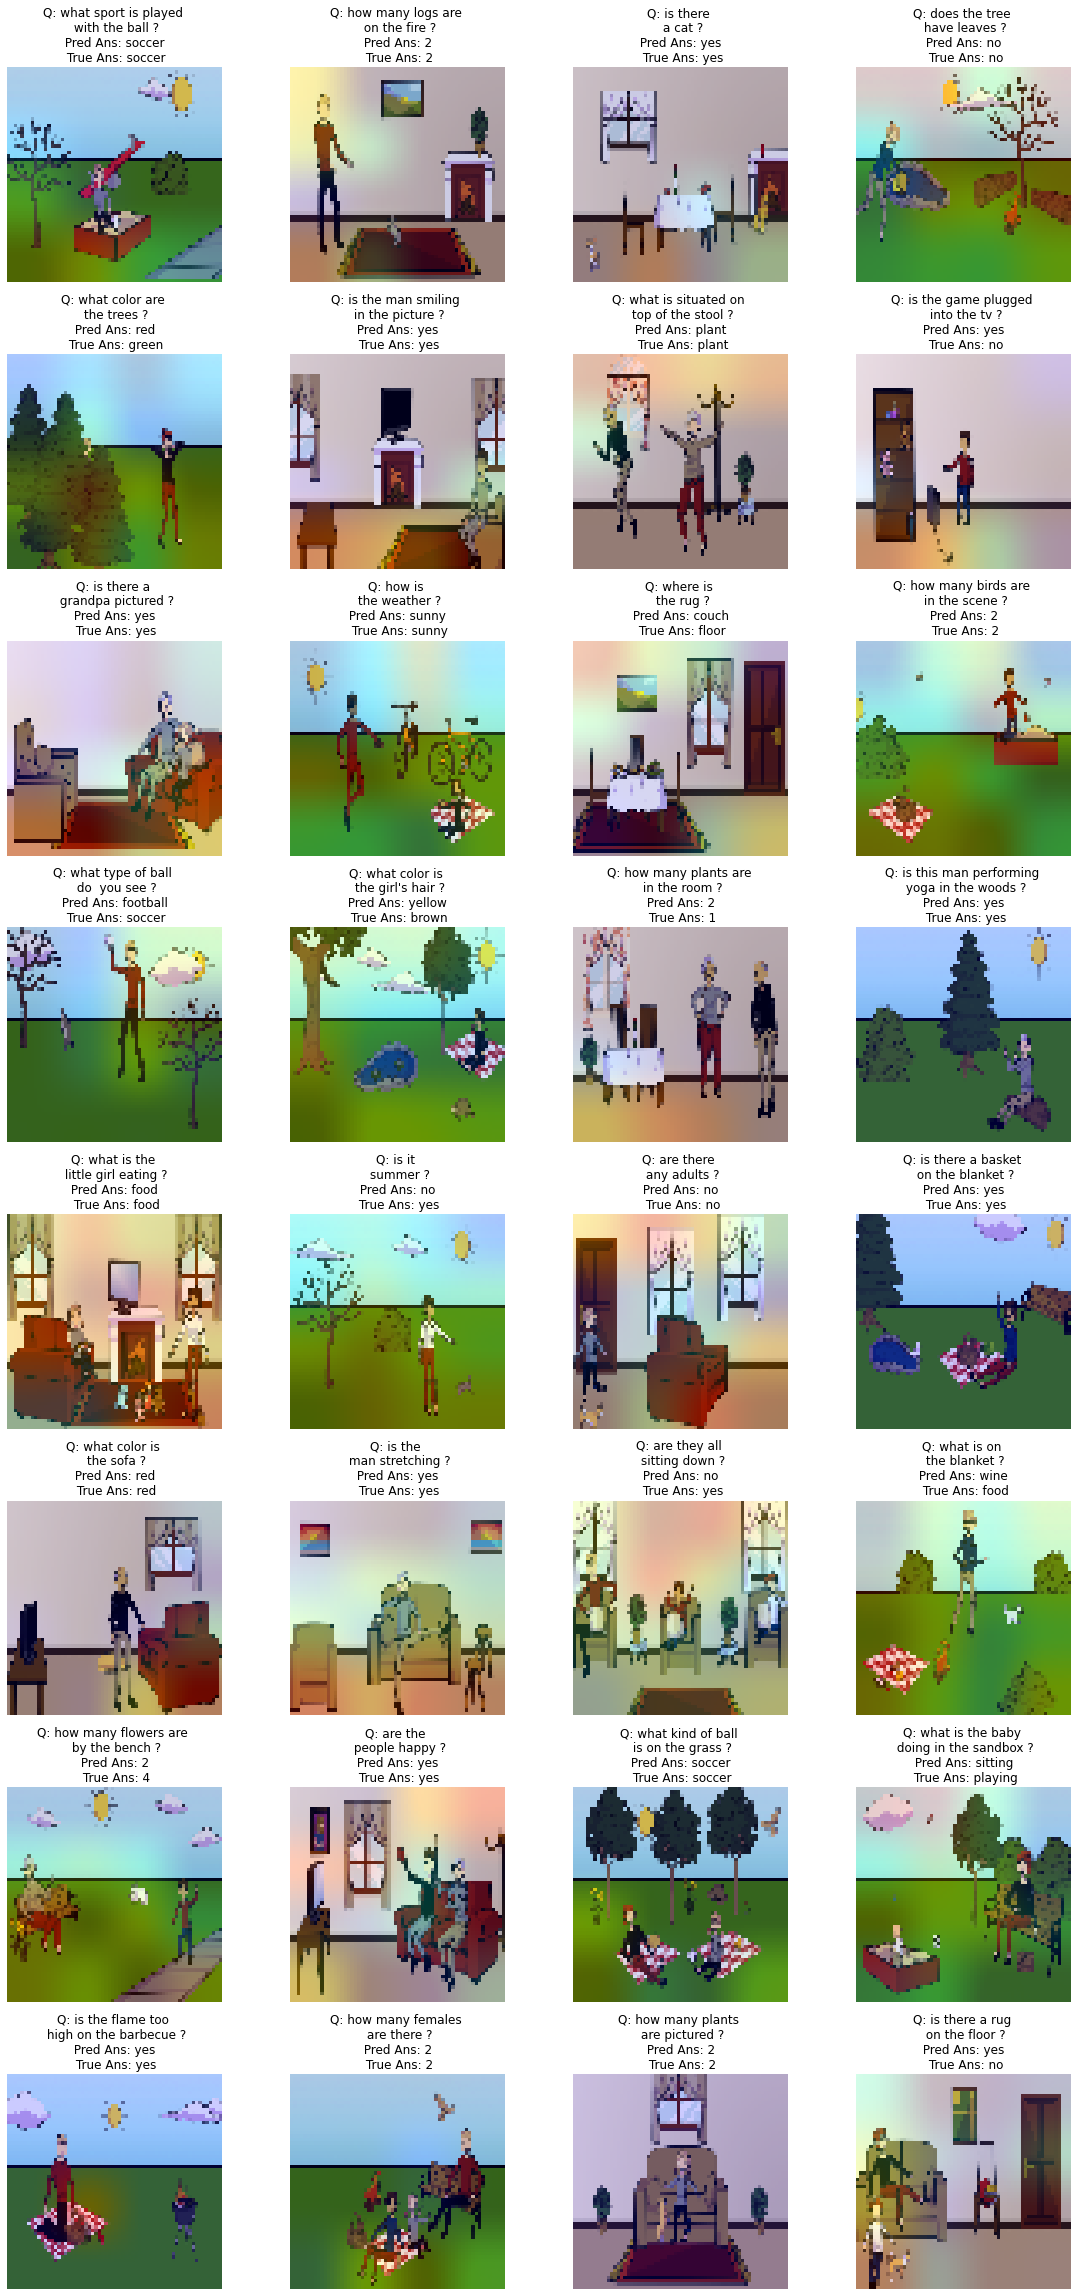

In [18]:
#  Let's check results on some validation samples

# last_conv_layer_name = 'block4_conv4'
last_conv_layer_name = 'block5_conv4'
# last_conv_layer_name = 'block5_pool'

for batch in val_dataset.shuffle(20).take(1):
    imgs_batch = batch[0][0]
    q_batch = batch[0][1]
    ans_batch = batch[1]
    answer_texts = [answers[i] for i in ans_batch]
    preds = model.predict(batch[0])
    pred_texts = [answers[i] for i in np.argmax(preds, axis=1)]
    q_orig = []
    for q in q_batch:
        q = num_to_token(q).numpy()
        q = [t.decode("utf-8") for t in q]
        q = list(filter(('[UNK]').__ne__, q))
        q.insert(int(len(q) / 2), '\n')
        q = ' '.join(q)
        q_orig.append(q)
    _, ax = plt.subplots(8, 4, figsize=(16, 32))
    for i in range(32):
        example_input = (np.array([imgs_batch[i]]), np.array([q_batch[i]]))
        heatmap = make_gradcam_heatmap(example_input, model, last_conv_layer_name)
        img = get_gradcam(np.array(imgs_batch[i]), heatmap, alpha=0.001)
        title = f"Q: {q_orig[i]}\n Pred Ans: {pred_texts[i]} \n True Ans: {answer_texts[i]}"
        ax[i // 4, i % 4].imshow(img)
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.tight_layout()
plt.show()


## Conclusion


In practice, you should train for around 10 epochs or more. Each epoch takes approximately 7mn using a `GeForce RTX 2080 Ti` GPU. The model we trained at 50 epochs has an `Accuracy ≈ 50%.

